# Histogram Equalization and Contrast Stretching for Low-Contrast Images

**DCIT 407 — Image Processing Semester Project**  
**Group 3 | Level 400, 1st Semester**

---

## Setup & Installations

Installing all required libraries and importing them.

In [ ]:
%pip install opencv-python numpy matplotlib -q

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen

# Image URL (hosted on GitHub so it works anywhere)
image = "https://raw.githubusercontent.com/DCIT407-IMAGE-PROCESSING/Group_3/main/Data/low_contrast_image.jpg"

## 1. Introduction & Image Preparation

Loading our test image, converting it to grayscale, and examining its properties.

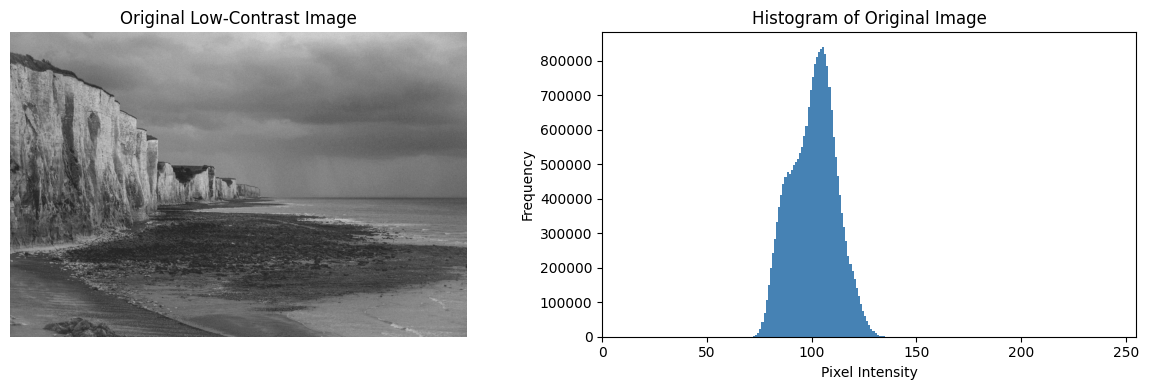

Image Shape  : (3828, 5742)
Min Intensity: 69
Max Intensity: 140
Mean         : 100.36
Std Deviation: 10.77
Intensity Range: 71


In [ ]:
# Download image from URL
resp = urlopen(image)
img_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
img_color = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

# Convert to grayscale
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# Display image and its histogram side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Original Low-Contrast Image")
axes[0].axis('off')

axes[1].hist(img_gray.ravel(), bins=256, range=(0, 256), color='steelblue', edgecolor='none')
axes[1].set_title("Histogram of Original Image")
axes[1].set_xlabel("Pixel Intensity")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim([0, 255])

plt.tight_layout()
plt.show()

# Print basic statistics
print(f"Image Shape  : {img_gray.shape}")
print(f"Min Intensity: {img_gray.min()}")
print(f"Max Intensity: {img_gray.max()}")
print(f"Mean         : {img_gray.mean():.2f}")
print(f"Std Deviation: {img_gray.std():.2f}")
print(f"Intensity Range: {img_gray.max() - img_gray.min()}")

## 2. Theory: Low Contrast & Histograms
### What is Low Contrast?

A **low-contrast image** is one where the pixel intensities are clustered within a narrow range instead of being spread across the full 0–255 scale. This makes the image look dull, washed out, or hazy — details become hard to see because bright and dark areas look too similar.

### Common Causes of Low Contrast

- **Poor lighting** — too dim or too bright when the photo was taken  
- **Fog, haze, or dust** — environmental conditions that scatter light  
- **Camera settings** — wrong exposure or aperture values  
- **Sensor limitations** — cheap cameras may capture a limited dynamic range  

### What is a Histogram?

A **histogram** is a bar chart that shows how many pixels in the image have each intensity value (0 = black, 255 = white). It gives us a quick visual summary of the brightness distribution.

- An image with **good contrast** has a histogram that spreads across most of the 0–255 range  
- A **low-contrast image** has a histogram where all the bars are bunched together in a small region  

### How Histograms Reveal Contrast Problems

By looking at the histogram of our original image above, we can see that the pixel values are concentrated in a narrow band. This confirms that the image is low-contrast — the full dynamic range is not being used.

The goal of contrast enhancement is to **spread out** these pixel values so that the image uses more of the available intensity range, making details more visible.

## 3. Theory: Contrast Stretching
### What is Contrast Stretching?

Contrast stretching is a technique used to enhance the visual quality of an image by adjusting its intensity levels.

For example, take a low-contrast image where most of its pixels sit in a narrow intensity range of 80-120 in a 0-255. Contrast stretching spreads the values of these pixels to now occupy 0-255. This results in dark becoming darker and bright becoming brighter.

Edges look clearer, objects separate from the background, and visibility of features improve significantly.


### The Formula

$$P_{out} = \frac{P_{in} - P_{min}}{P_{max} - P_{min}} \times 255$$

Where:
- $P_{in}$ = original pixel value  
- $P_{min}$ = minimum pixel value in the image  
- $P_{max}$ = maximum pixel value in the image  
- $P_{out}$ = new pixel value (between 0 and 255)  

### Advantages

- Very simple and fast to compute  
- Preserves the relative order of pixel values (no information is lost)  
- Produces natural-looking results  

### Limitations

- Doesn't work well if pixel values are already spread across the full range
- Sensitive to outliers (one very bright or dark pixel can reduce the effect)  
- Not suitable for images with multiple brightness regions. This requires the use of the histogram equalization instead.

## 4. Implementation: Contrast Stretching
Applying the contrast stretching formula to our low-contrast image.

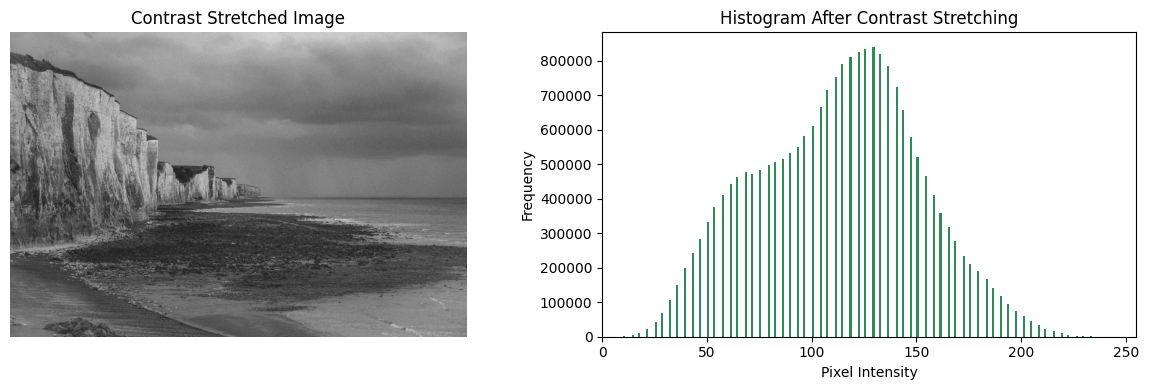

Before — Range: [69, 140], Mean: 100.36
After  — Range: [0, 255], Mean: 112.13


In [ ]:
def contrast_stretch(image):
    """Apply min-max contrast stretching to a grayscale image."""
    p_min, p_max = float(image.min()), float(image.max())
    stretched = (image.astype(np.float32) - p_min) / (p_max - p_min) * 255
    return np.clip(stretched, 0, 255).astype(np.uint8)

# Apply contrast stretching
img_stretched = contrast_stretch(img_gray)

# Display result
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(img_stretched, cmap='gray')
axes[0].set_title("Contrast Stretched Image")
axes[0].axis('off')

axes[1].hist(img_stretched.ravel(), bins=256, range=(0, 256), color='seagreen', edgecolor='none')
axes[1].set_title("Histogram After Contrast Stretching")
axes[1].set_xlabel("Pixel Intensity")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim([0, 255])

plt.tight_layout()
plt.show()

print(f"Before — Range: [{img_gray.min()}, {img_gray.max()}], Mean: {img_gray.mean():.2f}")
print(f"After  — Range: [{img_stretched.min()}, {img_stretched.max()}], Mean: {img_stretched.mean():.2f}")

## 5. Theory: Histogram Equalization

### What is Histogram Equalization?

**Histogram Equalization (HE)** is a non-linear technique that improves contrast by redistributing pixel intensities so that the histogram of the output image becomes approximately uniform (flat). Unlike contrast stretching which only scales the range, HE actually **changes the distribution** of pixel values.

### How It Works — The CDF Approach

The method uses the **Cumulative Distribution Function (CDF)** of the histogram:

1. Compute the histogram — count how many pixels have each intensity value
2. Compute the CDF — the running total of pixel counts up to each intensity
3. Normalize the CDF to the 0–255 range
4. Use the normalized CDF as a lookup table to map old pixel values to new ones

### Key Formulas

**Probability of each intensity:**

$$p_r(r_k) = \frac{n_k}{M \times N}$$

Where $n_k$ = number of pixels with intensity $r_k$, and $M \times N$ = total pixels.

**Cumulative Distribution Function:**

$$CDF(r_k) = \sum_{j=0}^{k} p_r(r_j)$$

**Transformation (new pixel value):**

$$s_k = \text{round}\left((L - 1) \times CDF(r_k)\right)$$

Where $L = 256$ (number of gray levels) and $s_k$ = new intensity for pixels that had intensity $r_k$.

### Advantages

- **Automatic** — no parameters to tune
- Provides **strong global contrast** enhancement
- Effective for dark or low-contrast images
- Simple to compute

### Limitations

- Can **over-enhance** some regions and look unnatural
- May **amplify noise** in smooth/flat areas
- Does not preserve overall brightness
- Not adaptive to local image regions

### Comparison with Contrast Stretching

| Feature | Contrast Stretching | Histogram Equalization |
|---|---|---|
| Type of Mapping | Linear | Non-linear |
| Control | User-defined range | Automatic |
| Contrast Improvement | Moderate | Strong |
| Noise Amplification | Low | Possible |

## 6. Implementation: Histogram Equalization
Applying histogram equalization using OpenCV's built-in function.

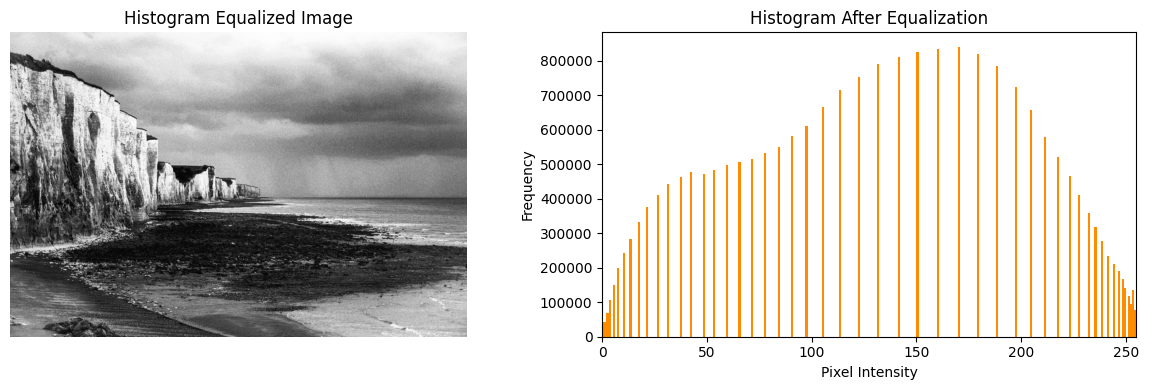

Before — Range: [69, 140], Mean: 100.36
After  — Range: [0, 255], Mean: 130.73


In [ ]:
# Apply histogram equalization
img_equalized = cv2.equalizeHist(img_gray)

# Display result
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(img_equalized, cmap='gray')
axes[0].set_title("Histogram Equalized Image")
axes[0].axis('off')

axes[1].hist(img_equalized.ravel(), bins=256, range=(0, 256), color='darkorange', edgecolor='none')
axes[1].set_title("Histogram After Equalization")
axes[1].set_xlabel("Pixel Intensity")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim([0, 255])

plt.tight_layout()
plt.show()

print(f"Before — Range: [{img_gray.min()}, {img_gray.max()}], Mean: {img_gray.mean():.2f}")
print(f"After  — Range: [{img_equalized.min()}, {img_equalized.max()}], Mean: {img_equalized.mean():.2f}")

## 7. Comparison & Analysis
Placing all three images and their histograms side by side to compare.

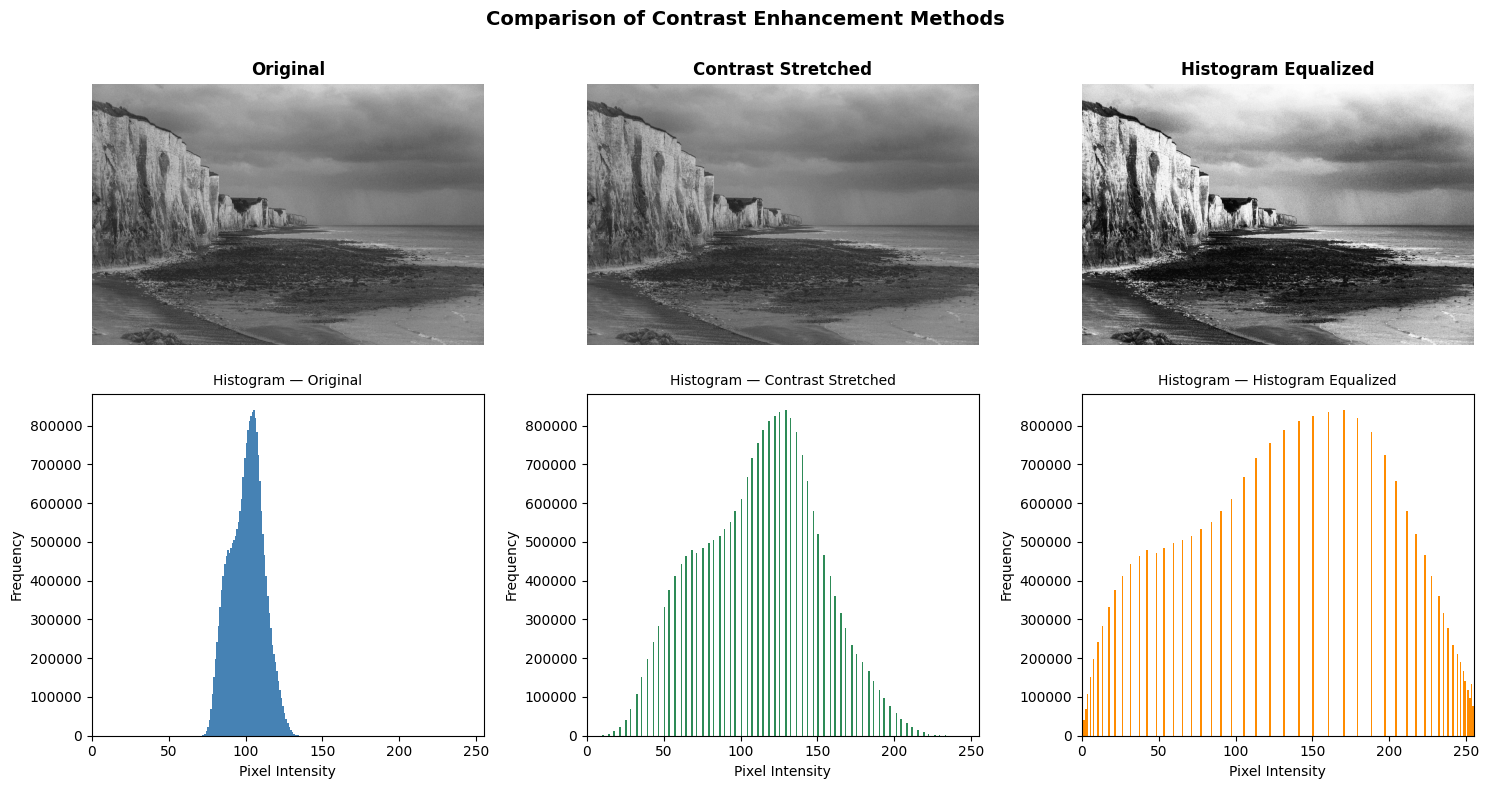


Method                    Min    Max    Mean     Std      Range 
------------------------------------------------------------
Original                  69     140    100.36   10.77    71    
Contrast Stretched        0      255    112.13   38.66    255   
Histogram Equalized       0      255    130.73   73.76    255   


In [ ]:
# Side-by-side comparison of all methods
images = [img_gray, img_stretched, img_equalized]
titles = ["Original", "Contrast Stretched", "Histogram Equalized"]
colors = ["steelblue", "seagreen", "darkorange"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i in range(3):
    # Row 1: Images
    axes[0, i].imshow(images[i], cmap='gray')
    axes[0, i].set_title(titles[i], fontsize=12, fontweight='bold')
    axes[0, i].axis('off')

    # Row 2: Histograms
    axes[1, i].hist(images[i].ravel(), bins=256, range=(0, 256), color=colors[i], edgecolor='none')
    axes[1, i].set_title(f"Histogram — {titles[i]}", fontsize=10)
    axes[1, i].set_xlabel("Pixel Intensity")
    axes[1, i].set_ylabel("Frequency")
    axes[1, i].set_xlim([0, 255])

plt.suptitle("Comparison of Contrast Enhancement Methods", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Statistics comparison table
print(f"\n{'Method':<25} {'Min':<6} {'Max':<6} {'Mean':<8} {'Std':<8} {'Range':<6}")
print("-" * 60)
for img, name in zip(images, titles):
    print(f"{name:<25} {img.min():<6} {img.max():<6} {img.mean():<8.2f} {img.std():<8.2f} {img.max()-img.min():<6}")

## 8. Discussion

### Results Analysis

**Contrast Stretching:**
- The histogram is stretched to cover the full 0–255 range, but its overall shape stays the same
- The image looks more natural since pixel relationships are preserved
- Works best when the original range is narrow and there are no extreme outliers

**Histogram Equalization:**
- The histogram is spread out more evenly — pixel values are redistributed, not just scaled
- Produces stronger contrast improvement, but can look slightly over-processed
- May amplify noise in areas that were originally smooth

### Strengths & Limitations

| | Contrast Stretching | Histogram Equalization |
|---|---|---|
| **Strengths** | Simple, fast, natural results | Strong enhancement, automatic |
| **Limitations** | Only scales range, sensitive to outliers | Can over-enhance, amplifies noise |
| **Best for** | Subtle correction | Strong contrast boost |

### Real-World Applications

- **Medical Imaging** — enhancing X-rays and CT scans for better diagnosis
- **Satellite Imagery** — improving visibility of terrain features
- **Surveillance** — enhancing details in poorly lit security footage
- **Photography** — correcting photos taken in fog, haze, or low light
- **Document Scanning** — improving readability of faded documents

---

## 9. Conclusion

In this project, we explored two fundamental techniques for enhancing low-contrast images:

1. **Contrast Stretching** linearly maps pixel values to the full 0–255 range. It is simple, fast, and produces natural results, but only scales the existing distribution without changing its shape.

2. **Histogram Equalization** redistributes pixel intensities using the cumulative distribution function (CDF), producing a more uniform histogram. It gives stronger contrast improvement but may over-enhance some regions or amplify noise.

Both methods successfully improved the visibility of details in our low-contrast test image. For most basic use cases, **contrast stretching** is a good starting point. For images that need stronger enhancement, **histogram equalization** is the better choice.

## References
1. Gonzalez, R. C., & Woods, R. E. (2018). *Digital Image Processing* (4th ed.). Pearson.  
2. OpenCV Documentation — Histogram Equalization: [https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html](https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html)  
3. OpenCV Documentation — Histograms: [https://docs.opencv.org/4.x/d1/db7/tutorial_py_histogram_begins.html](https://docs.opencv.org/4.x/d1/db7/tutorial_py_histogram_begins.html)